### Import dependencies

In [1]:
import pandas as pd
from pandas.plotting import lag_plot

import numpy as np

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

from sklearn import linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller



import os
import matplotlib.pyplot as plt
import cProfile


### Setup

Helpers

In [2]:
def path_to_symbols(base_dir="data"):
    """Return a list of symbols from a directory by removing the file extension `csv`."""
    file_list = os.listdir(base_dir)
    res =[]

    for file in file_list:
        file = file.split('.')
        if file[1] =="csv":
            res.append(file[0])
    return res
        
def symbol_to_path(symbol, base_dir= "data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_container = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')
    
    


    
    if len(symbols) > 1:
        for symbol in symbols:
            if symbol == "SPY":
                df_temp = pd.read_csv("data/" + "SPY" + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
                df_temp = df_temp.rename(columns={'Adj Close':"SPY"})
                df_container = df_container.join(df_temp)
                df_container = df_container.dropna();
            else:
            
                df_temp = pd.read_csv("data/" + symbol + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
                df_temp = df_temp.rename(columns={'Adj Close':symbol})
                df_container = df_container.join(df_temp)
    else:
        df_temp = pd.read_csv("data/" + symbols[0] + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
        df_temp = df_temp.rename(columns={'Adj Close':symbols[0]})
        df_container = df_container.join(df_temp)

    return df_container

def normalise_data(df:pd.DataFrame, frame_of_reference= 0):
    """Normalises the data based on the frame of reference"""
    return df/df.iloc[frame_of_reference]

def get_rolling_mean(df:pd.DataFrame, window = 20):
    return df.rolling(window).mean()

def get_rolling_std(df:pd.DataFrame, window = 20):
    return df.rolling(window).std()

def get_bollinger_bands(df:pd.DataFrame, window = 20, num_std = 2):
    """ Returns a tuple of Bollinger Bands® `(upper band, rolling mean , lower band)`"""

    rolling_mean = get_rolling_mean(df, window)
    std = get_rolling_std(df, window)
    upper_band = rolling_mean + num_std * std
    lower_band = rolling_mean - num_std * std

    return (upper_band, rolling_mean, lower_band)

def get_daily_returns(df:pd.DataFrame):
    df_lag = df.shift(1)
    df_res = ((df/df_lag) - 1) * 100

    df_res = df_res.fillna(0)

    return df_res

def fill_missing_values(df):
    df.ffill(axis=0, inplace=True)
    df.bfill(axis=0, inplace=True)


Regressors/Predictors

In [26]:
# linear
def linear_regression(df:pd.DataFrame, window=100):
    """
    `df`dataframe to create regression from \n
    `window` the number of days from the dataframe to consider in the regression
    
    """
    # TODO: make this seperate every col in df and create its regression individually
    res = df.tail(window)
    res = res.reset_index(drop=True, inplace=False)
    res.insert(0, 'index',res.index)
    temp_array = res.to_numpy()
    temp_array = np.transpose(temp_array) 
    
    reg = lm.LinearRegression()
    
    reg.fit(temp_array[0].reshape(-1, 1) ,temp_array[1])

    x = np.linspace(int(temp_array[0][0])+1, int(temp_array[0][-1])+1 + window, window+window+1)
    b = reg.intercept_
    m = reg.coef_
    y = m * x + b
    # print(temp_array[0][0])

    # print(y)
    # print(m)
    # print(x)
    # print(b)

    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=window)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')



    fin = df.tail(window)
    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])

    fin.insert(0, "regression", y)
    # fin.pop("SPY")


    return fin

# poly
def polynomial_regression(df:pd.DataFrame, window=100, degree=3):
    # TODO: make this seperate every col in df and create its regression individually
    
    # convert data to scikit-learn friendly format
    res = df.tail(window)
    res = res.reset_index(drop=True, inplace=False)
    res.insert(0, 'index',res.index)
    temp_array = res.to_numpy()
    temp_array = np.transpose(temp_array) 

    x_train = temp_array[0]
    y_train = temp_array[1]

    # create poly features matrix
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train.reshape(-1, 1))

    # fit poly regression model
    model = lm.LinearRegression()
    model.fit(x_poly, y_train)


    # use results / create predictions
    x_test = np.linspace(int(temp_array[0][0])+1, int(temp_array[0][-1])+1 + window, window+window+1)
    x_test_poly = poly_features.transform(x_test.reshape(-1, 1))
    y_pred = model.predict(x_test_poly)




    # move results to dataframe
    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=window)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')

    fin = df.tail(window)
    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])


    fin.insert(0, "regression", y_pred)
    # fin.pop("SPY")


    return fin

# spline (interpolator)
def create_regression_3(df:pd.DataFrame, window=100, knots=10):
    """
    Spline regression, bad 
    """

    # convert data to scikit-learn friendly format
    res = df.tail(window)
    res = res.reset_index(drop=True, inplace=False)
    res.insert(0, 'index',res.index)
    temp_array = res.to_numpy()
    temp_array = np.transpose(temp_array) 

    x_train = temp_array[0]
    y_train = temp_array[1]

    # Step 3: Create a spline features matrix
    # knots = 3  # Set knot points, which divide the data into segments
    spline_features = SplineTransformer(degree=3, n_knots=knots)
    x_spline = spline_features.fit_transform(x_train.reshape(-1, 1))

    # Step 4: Fit a linear regression model
    model = lm.LinearRegression()
    model.fit(x_spline, y_train)

    # Step 5: Make predictions and visualize the results
    x_test = np.linspace(int(temp_array[0][0])+1, int(temp_array[0][-1])+1 + window, window+window+1)  # Generate test data for prediction
    x_test_spline = spline_features.transform(x_test.reshape(-1, 1))
    y_pred = model.predict(x_test_spline)

    # move results to dataframe
    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=window)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')

    fin = df.tail(window)
    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])


    fin.insert(0, "regression", y_pred)
    # fin.pop("SPY")


    return fin

# ARIMA    
def create_prediction(df:pd.DataFrame, p=10,d=2,q=5, days_to_predict = 30):

    
    # Step 3: Decompose the Time Series (optional)
    decomposition = seasonal_decompose(df['SPY'], model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Step 4: Stationarize the Data (if needed)

    # Step 5: Choose a Forecasting Model (e.g., ARIMA)
    model = ARIMA(df['SPY'], order=(p, d, q))  # Replace p, d, q with appropriate values

    # Step 6: Train the Model
    model_fit = model.fit()

    # Step 7: Make Forecasts
    forecast_periods = days_to_predict  # Number of periods to forecast
    forecast = model_fit.forecast(steps=forecast_periods)


    
    
    # Step 8: Visualize Forecasts
    # plt.figure(figsize=(12, 6))
    # plt.plot(df.index, df['SPY'], label='Original Data')
    # plt.plot(pd.date_range(start=df.index[-1], periods=forecast_periods+1), [df['SPY'].iloc[-1]] + list(forecast), label='Forecast', color='red')
    # plt.title('Time Series Forecast')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.show()

    # move results to dataframe
    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=days_to_predict-1)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')

    fin = df.tail(days_to_predict)
    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])

    df_pred = pd.DataFrame(index=new_date_range)
    df_pred.insert(0, "regression", forecast)



    fin=fin.join(df_pred)

    return fin



# Running Code

In [4]:
def test_run():
    # Define a date range
    dates = pd.date_range('2010-03-01', '2010-04-29')
    # dates = pd.date_range('2010-01-01', '2010-12-30')
    # dates = pd.date_range('2006-01-01', '2013-12-30')

    # Choose stock symbols to read
    symbols = path_to_symbols()
    print(symbols)
    symbols = [symbols[4]]
    
    # data collection / clean-up
    df = get_data(symbols, dates)
    fill_missing_values(df)
    
    df = normalise_data(df)
    window = 20
    
    # generating regression(s)
    # reg_df = create_regression(df)      # linear reg
    # reg_df_2 = create_regression_2(df)  # poly reg
    # reg_df_3 = create_regression_3(df)  # spline reg
    # ens_df = (reg_df_3 + reg_df_2 + reg_df)/3      # average of regs
    pred = create_prediction(df, days_to_predict=100)

    # df=df-1
    # PLOTTING DATA
    # ax = df.plot(title="normalised price")
    # ax.set_xlabel("Date")
    # ax.set_ylabel("Price")

    # bx = get_daily_returns(df).plot(title="daily returns")
    # bx.set_xlabel("Date")
    # bx.set_ylabel("Price")

    # cx = reg_df.plot(title="Predicted")
    # cx = reg_df_2.plot(label="Predicted",ax=cx)
    # cx = ens_df.plot(title="Predicted")
    # cx = ens_df.plot(label="Predicted", ax=ax)

    # dx = reg_df_3.plot(title="epic")

    bb = get_bollinger_bands(df, window)
    # ub_df = bb[0]
    rm_df = bb[1].shift(-10)
    # lb_df = bb[2]
    # ub_df.plot(label="upper mean", ax=ax)
    # rm_df.plot(ax=ax)
    # lb_df.plot(label="lower mean", ax=ax)



if __name__ == '__main__':
    test_run()

    # profile the performance of the code
    # cProfile.run("test_run()")


['GLD', 'GOOG', 'IBM', 'NVDA', 'SPY', 'XOM', 'z_AMZN']


c:\Users\LENOVO\miniconda3\envs\stock_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\miniconda3\envs\stock_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Experimental Setup

c:\Users\LENOVO\miniconda3\envs\stock_pred\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\miniconda3\envs\stock_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\miniconda3\envs\stock_pred\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ensemble
                  SPY  regression
2010-05-31  85.073021         NaN
2010-06-01  83.641800         NaN
2010-06-02  85.819756         NaN
2010-06-03  86.115341         NaN
2010-06-04  83.089539         NaN
...               ...         ...
2010-09-23        NaN  112.185550
2010-09-24        NaN  113.073624
2010-09-25        NaN  113.545818
2010-09-26        NaN  114.348294
2010-09-27        NaN         NaN

[127 rows x 2 columns]


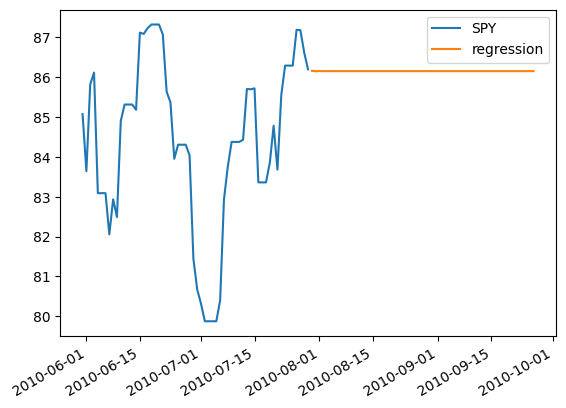

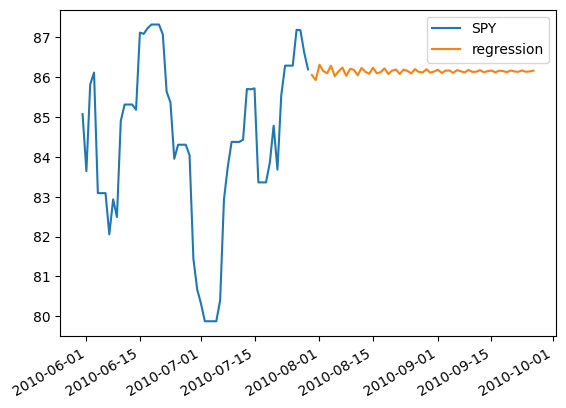

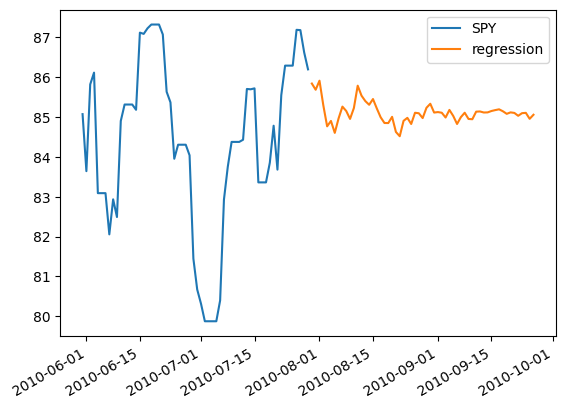

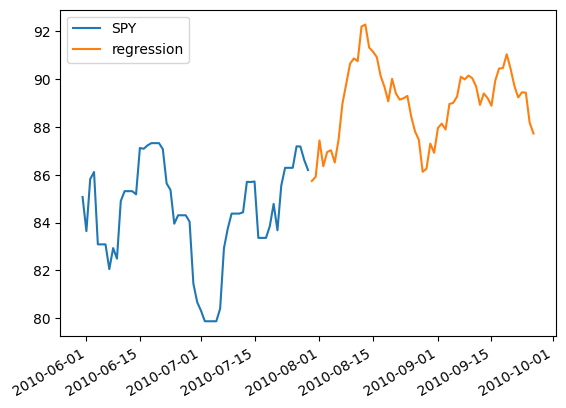

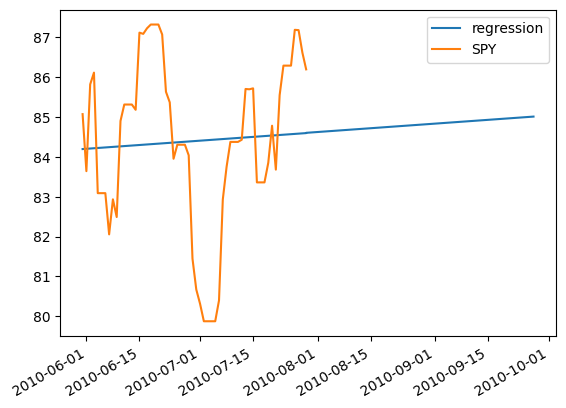

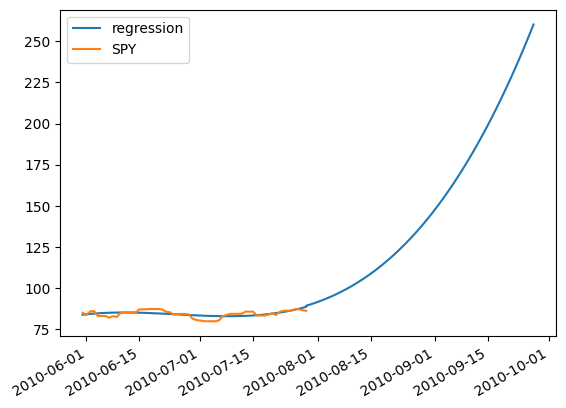

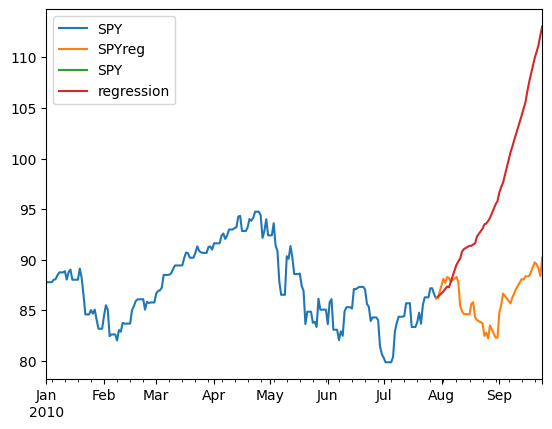

In [42]:
def create_prediction_2(df:pd.DataFrame, p=4,d=1,q=0, num_days_to_predict =30):

    # lag_plot(df["SPY"], lag=3)


    # Split data to training and test data 70% - 30%
    training_data, test_data = df[0:int(len(df) * 0.7)], df[int(len(df) * 0.7):]

    training_data = training_data.values
    test_data = test_data.values

    history = [x for x in training_data]
    model_predictions = []

    N_test_observations = len(test_data)  # Include the additional days in the loop

    models = []

    for time_point in range(N_test_observations):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
        models.append(model_fit)

    pred = models[-1].forecast(steps=num_days_to_predict)

    MSE_error = mean_squared_error(test_data, model_predictions[:len(test_data)])
    print('Testing Mean Squared Error is {}'.format(MSE_error))

    test_set_range = df[int(len(df)*0.7):].index
    # plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
    # plt.plot(test_set_range, test_data, color='red', label='Actual Price')
    # plt.title('TESLA Prices Prediction')
    # plt.xlabel('Date')
    # plt.ylabel('Prices')
    # plt.legend()
    # plt.show()

    # move results to dataframe
    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=num_days_to_predict-1)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')

    fin = df.tail(num_days_to_predict)
    fin = pd.concat([fin, pd.DataFrame(index=new_date_range)])

    df_pred = pd.DataFrame(index=new_date_range)
    df_pred.insert(0, "regression", pred)



    fin=fin.join(df_pred)

    return fin

def ensemble(df:pd.DataFrame, symbols, prediction_time=60):
    
    
    # create predictions based on a day, a week, a month, and a quarter
    periods = [1 , 7 , 30 , 90]
    results = []


    for period in periods:
        df_p = create_prediction(df,p=period,d=1,q=2,days_to_predict=prediction_time)
        results.append(df_p)
        

    # mix results
    linear_reg = linear_regression(df, prediction_time)
    polynomial_reg = polynomial_regression(df, prediction_time)

    results.append(linear_reg)
    results.append(polynomial_reg)


    df_ensemble =  results[0]/12 + results[1]/12 + 2*results[2]/12 + 4*results[3]/12 + 2*results[4]/12 + 2*results[5]/12

        

    for result in results:
        result.plot()
    ax = df.plot()

    last_date = df.index[-1]
    new_end_date = last_date + pd.DateOffset(days=prediction_time-1)
    new_date_range = pd.date_range(start=last_date, end=new_end_date, freq='D')

    df_new = get_data(symbols, new_date_range)
    df_new = df_new.dropna()


    
    # print("real")
    # print(df_new)

    

    print("ensemble")
    print(df_ensemble)
    df_new=df_new.join(df_ensemble,lsuffix="reg")

    df_new.plot(ax=ax)
    # MSE_error = mean_squared_error(df_new["regression"], df_new["SPY"])
    # print('Testing Mean Squared Error is {}'.format(MSE_error))

    return df_new





def experiment():
    # Define a date range
    # dates = pd.date_range('2010-03-01', '2010-10-29')
    dates = pd.date_range('2010-01-01', '2010-7-29')
    # dates = pd.date_range('2010-01-01', '2010-12-30')
    # dates = pd.date_range('2006-01-01', '2013-12-30')

    # Choose stock symbols to read
    symbols = path_to_symbols()
    symbols = [symbols[4]]
    
    # data collection / clean-up
    df = get_data(symbols, dates)
    fill_missing_values(df)
    
    # df = normalise_data(df)
    

    df_ens = ensemble(df, symbols=symbols)

    

    
if __name__ == '__main__':
    experiment()
